In [6]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42

# Some useful functions

In [8]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def LeakyRelu(x, beta):
    x[x < 0] *= beta 
    return x

def gamma_mlp_gat_fn(x_i, x_j, row1, row2, row3, row4, eigen, n, sigma, i, neigh):
    val1 = row1[0]*x_i + row1[1]*x_j
    val2 = row2[0]*x_i + row2[1]*x_j
    val3 = row3[0]*x_i + row3[1]*x_j
    val4 = row4[0]*x_i + row4[1]*x_j
    h    = np.asarray([1, 1, -1, -1])
    
    temp = np.asarray([val1,val2,val3,val4])
    temp = LeakyRelu(temp, 0.2)
    classification_of_pairs = h@temp + 8*np.sqrt(np.log(n)) * sigma*np.sign(np.asarray(np.multiply(eigen[neigh], eigen[i]).T)[0])
    temp = classification_of_pairs - (classification_of_pairs).max()
    ex = np.exp(temp)
    
    return ex / np.sum(ex), classification_of_pairs

def gamma_gat_fn(x_i, x_j, a1, a2, b):
    temp = LeakyRelu(a1*x_i + a2*x_j + b, 0.2)
    temp = temp - max(temp)
    ex = np.exp(temp)
    return ex / np.sum(ex)

def all_gammas(X, adjlist, row1, row2, row3, row4, a1, a2, b, eigen, n, sigma):
    inter_gammas_mlp_gat = []
    intra_gammas_mlp_gat  = []
    inter_gammas_gat = [[],[]]
    intra_gammas_gat  = [[],[]]

    pairs_intra = 0
    pairs_inter = 0

    n_intra = 0
    n_inter = 0

    N = int(len(X)/2)
    x_mlp_gat = np.zeros(len(X))
    x_gat = np.zeros(len(X))
    x_gcn = np.zeros(len(X))
    
    for i in range(len(X)):
        
        gamma_gat_head1 = gamma_gat_fn(X[i], X[adjlist[i]], a1, a2, b)
        gamma_gat_head2 = gamma_gat_fn(X[i], X[adjlist[i]], -a1, -a2, -b)
        gamma_mlp_gat, pairs_mlp_gat = gamma_mlp_gat_fn(X[i], X[adjlist[i]], row1, row2, row3, row4, eigen, n, sigma, i, adjlist[i])
        gamma_gcn = np.ones(len(adjlist[i]))/len(adjlist[i])
        
        x_mlp_gat[i] = np.dot(gamma_mlp_gat, X[adjlist[i]])
        x_gat[i] = 0.5*np.dot(gamma_gat_head1, X[adjlist[i]]) + 0.5*np.dot(gamma_gat_head2, X[adjlist[i]])
        x_gcn[i] = np.dot(gamma_gcn, X[adjlist[i]])
        
        ct = 0
        for j in adjlist[i]:
            if (j < N and i < N) or (j >= N and i >= N):
                intra_gammas_gat[0].append(gamma_gat_head1[ct])
                intra_gammas_gat[1].append(gamma_gat_head2[ct])
                intra_gammas_mlp_gat.append(gamma_mlp_gat[ct])
                pairs_intra += pairs_mlp_gat[ct] > 0
                n_intra += 1
            elif (j < N and i >= N) or (j >= N and i < N):
                inter_gammas_gat[0].append(gamma_gat_head1[ct])
                inter_gammas_gat[1].append(gamma_gat_head2[ct])
                inter_gammas_mlp_gat.append(gamma_mlp_gat[ct])
                pairs_inter += pairs_mlp_gat[ct] <= 0
                n_inter += 1
            ct += 1
            
    class_pair_intra = pairs_intra/n_intra
    class_pair_inter = pairs_inter/n_inter
            
    return x_mlp_gat, x_gat, x_gcn, class_pair_intra, class_pair_inter, np.asarray(intra_gammas_mlp_gat), np.asarray(inter_gammas_mlp_gat), np.asarray(intra_gammas_gat), np.asarray(inter_gammas_gat)

# Create data

In [9]:
n = 1000
d = int(np.ceil(n/(np.log(n)**2)))
p = 0.5
heads = 2 # does not work for another number

sizes = [int(n/2), int(n/2)]

std_ = 0.1
q_lb = (np.log(n)**2)/n

qs = np.linspace(q_lb, p, 30, endpoint=True)

ground_truth = np.concatenate((np.zeros(int(n/2)), np.ones(int(n/2))))

intra_avg_mlp_gat = []
intra_std_mlp_gat = []
inter_avg_mlp_gat = [] 
inter_std_mlp_gat = [] 

intra_avg_gat = [[],[]]
intra_std_gat = [[],[]]
inter_avg_gat = [[],[]]
inter_std_gat = [[],[]]

acc_mlp_gat = []
acc_gat = []
acc_gcn = []
acc_lin = []

acc_mlp_gat_std = []
acc_gat_std = []
acc_gcn_std = []
acc_lin_std = []

acc_pairs_intra = []
acc_pairs_inter = []

acc_pairs_intra_std = []
acc_pairs_inter_std = []

trials = 10

for q in qs:
    
    sum_intra_avg_mlp_gat = 0
    sum_intra_std_mlp_gat = 0
    sum_inter_avg_mlp_gat = 0
    sum_inter_std_mlp_gat = 0
    
    sum_intra_avg_gat = [0,0]
    sum_intra_std_gat = [0,0]
    sum_inter_avg_gat = [0,0]
    sum_inter_std_gat = [0,0]
    
    pairs_intra_list = []
    pairs_inter_list = []
    
    acc_mlp_gat_list = []
    acc_gat_list = []
    acc_gcn_list = []
    acc_lin_list = []
    
    mu = 1*std_/(2*np.sqrt(d))
    
    for trial in range(trials):
        
#         g = nx.stochastic_block_model(sizes, probs, seed=0)
        probs = [[p,q], [q,p]]
        g = nx.stochastic_block_model(sizes, probs)

        adjlist = [[v for v in g.neighbors(i)] for i in range(n)]
        for i in range(len(adjlist)):
            adjlist[i].append(i)
        _, eigen = np.linalg.eig(nx.to_numpy_matrix(g))
        eigen = (eigen[:,1])

        X = np.zeros((n,d))
        X[:int(n/2)] = -mu
        X[int(n/2):] = mu
        noise = std_*np.random.randn(n,d)
        X = X + noise

        R = 1
        mu_ = mu*np.ones(d)
        w = (R/np.linalg.norm(mu_))*mu_
        Xw = X@w

        wmu_ = 1
        row1 = np.asarray([wmu_,wmu_])
        row2 = np.asarray([-wmu_,-wmu_])
        row3 = np.asarray([wmu_,-wmu_])
        row4 = np.asarray([-wmu_,wmu_])
        
        a1 = R/np.sqrt(2.0)
        a2 = a1
        b = -np.dot(w,mu_)*a1

        x_mlp_gat, x_gat, x_gcn, class_pair_intra, class_pair_inter, intra_gammas_mlp_gat, inter_gammas_mlp_gat, intra_gammas_gat, inter_gammas_gat = all_gammas(Xw, adjlist, row1, row2, row3, row4, a1, a2, b, eigen, n, std_)

        pred = np.zeros(n)
        pred[x_mlp_gat > 0] = 1
        tmp = 1 - np.sum(np.abs(pred - ground_truth))/n
        acc_mlp_gat_list.append(tmp)
        
        pred = np.zeros(n)
        pred[x_gat > 0] = 1
        tmp = 1 - np.sum(np.abs(pred - ground_truth))/n
        acc_gat_list.append(tmp)
        
        pred = np.zeros(n)
        pred[x_gcn > 0] = 1
        tmp = 1 - np.sum(np.abs(pred - ground_truth))/n
        acc_gcn_list.append(tmp)
        
        pred = np.zeros(n)
        pred[Xw > 0] = 1
        tmp = 1 - np.sum(np.abs(pred - ground_truth))/n
        acc_lin_list.append(tmp)
        
        sum_intra_avg_mlp_gat += intra_gammas_mlp_gat.mean()
        sum_intra_std_mlp_gat += intra_gammas_mlp_gat.std()
        sum_inter_avg_mlp_gat += inter_gammas_mlp_gat.mean()
        sum_inter_std_mlp_gat += inter_gammas_mlp_gat.std()
        
        for head in range(heads):
            sum_intra_avg_gat[head] += intra_gammas_gat[head].mean()
            sum_intra_std_gat[head] += intra_gammas_gat[head].std()
            sum_inter_avg_gat[head] += inter_gammas_gat[head].mean()
            sum_inter_std_gat[head] += inter_gammas_gat[head].std()
        
        pairs_intra_list.append(class_pair_intra)
        pairs_inter_list.append(class_pair_inter)
       
    intra_avg_mlp_gat.append(sum_intra_avg_mlp_gat/trials)
    intra_std_mlp_gat.append(sum_intra_std_mlp_gat/trials)
    inter_avg_mlp_gat.append(sum_inter_avg_mlp_gat/trials)
    inter_std_mlp_gat.append(sum_inter_std_mlp_gat/trials)
    
    for head in range(heads):
        intra_avg_gat[head].append(sum_intra_avg_gat[head]/trials)
        intra_std_gat[head].append(sum_intra_std_gat[head]/trials)
        inter_avg_gat[head].append(sum_inter_avg_gat[head]/trials)
        inter_std_gat[head].append(sum_inter_std_gat[head]/trials)
    
    acc_mlp_gat.append(np.asarray(acc_mlp_gat_list).mean())
    acc_gat.append(np.asarray(acc_gat_list).mean())
    acc_gcn.append(np.asarray(acc_gcn_list).mean())
    acc_lin.append(np.asarray(acc_lin_list).mean())
    
    acc_pairs_intra.append(np.asarray(pairs_intra_list).mean())
    acc_pairs_inter.append(np.asarray(pairs_inter_list).mean())
    
    acc_mlp_gat_std.append(np.asarray(acc_mlp_gat_list).std())
    acc_gat_std.append(np.asarray(acc_gat_list).std())
    acc_gcn_std.append(np.asarray(acc_gcn_list).std())
    acc_lin_std.append(np.asarray(acc_lin_list).std())
    
    acc_pairs_intra_std.append(np.asarray(pairs_intra_list).std())
    acc_pairs_inter_std.append(np.asarray(pairs_inter_list).std())
    

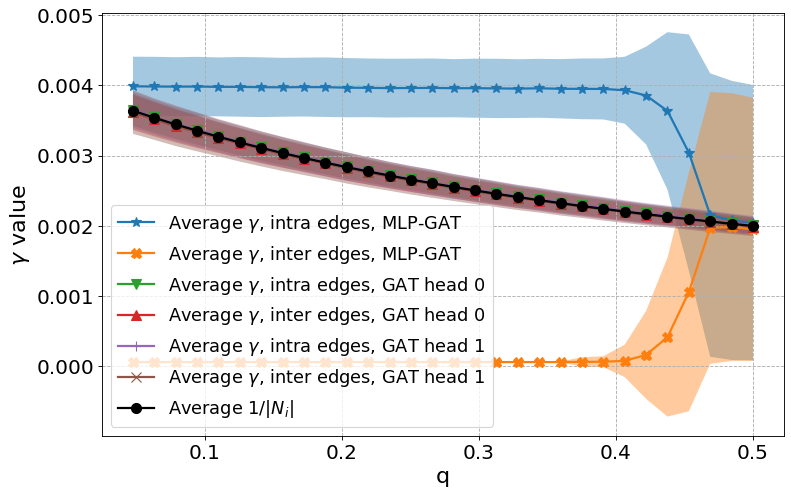

In [10]:
fig = plt.figure(figsize=(11, 7), dpi=80)

plt.plot(qs,intra_avg_mlp_gat, linewidth=2, linestyle='-', marker='*', markersize=9, label='Average $\gamma$, intra edges, MLP-GAT')
plt.fill_between(qs,np.asarray(intra_avg_mlp_gat)-np.asarray(intra_std_mlp_gat),np.asarray(intra_avg_mlp_gat)+np.asarray(intra_std_mlp_gat),alpha=0.4)

plt.plot(qs,inter_avg_mlp_gat, linewidth=2, linestyle='-', marker='X', markersize=9, label='Average $\gamma$, inter edges, MLP-GAT')
plt.fill_between(qs,np.asarray(inter_avg_mlp_gat)-np.asarray(inter_std_mlp_gat),np.asarray(inter_avg_mlp_gat)+np.asarray(inter_std_mlp_gat),alpha=0.4)

marker_intra = ['v','+']
marker_inter = ['^','x']
    
for head in range(heads):

    plt.plot(qs,intra_avg_gat[head], linewidth=2, linestyle='-', marker=marker_intra[head], markersize=9, label='Average $\gamma$, intra edges, GAT'+' head '+str(head))
    plt.fill_between(qs,np.asarray(intra_avg_gat[head])-np.asarray(intra_std_gat[head]),np.asarray(intra_avg_gat[head])+np.asarray(intra_std_gat[head]),alpha=0.4)

    plt.plot(qs,inter_avg_gat[head], linewidth=2, linestyle='-', marker=marker_inter[head], markersize=9, label='Average $\gamma$, inter edges, GAT'+' head '+str(head))
    plt.fill_between(qs,np.asarray(inter_avg_gat[head])-np.asarray(inter_std_gat[head]),np.asarray(inter_avg_gat[head])+np.asarray(inter_std_gat[head]),alpha=0.4)

gammas_gcn = []
for q in qs:
    gammas_gcn.append(1/(1+0.5*n*(p+q)))
    
plt.plot(qs,gammas_gcn, linewidth=2, linestyle='-', marker='o', markersize=9, color = 'black', label='Average $1/|N_i|$')

plt.grid(linestyle='dashed')
plt.legend(fontsize=16)
plt.xscale('linear')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xlabel('q', fontsize=20)
plt.ylabel('$\gamma$ value', fontsize=20)

fig.savefig("figures/gammas_GATv3_varying_q_hard_regime_p_05_extra_lines.pdf", dpi=400, bbox_inches='tight')

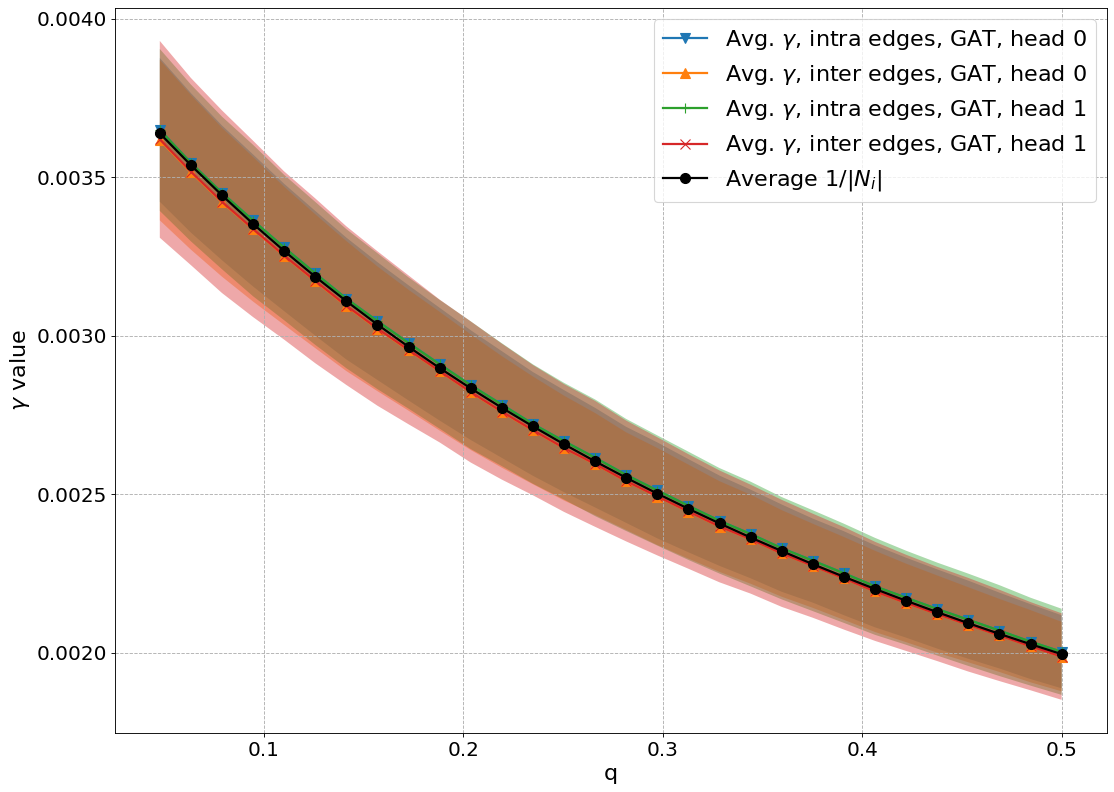

In [11]:
fig = plt.figure(figsize=(16, 12), dpi=80)

# plt.plot(qs,intra_avg_mlp_gat, linewidth=2, linestyle='-', marker='*', markersize=9, label='Average $\gamma$, intra MLP-GAT')
# plt.fill_between(qs,np.asarray(intra_avg_mlp_gat)-np.asarray(intra_std_mlp_gat),np.asarray(intra_avg_mlp_gat)+np.asarray(intra_std_mlp_gat),alpha=0.4)

# plt.plot(qs,inter_avg_mlp_gat, linewidth=2, linestyle='-', marker='X', markersize=9, label='Average $\gamma$, inter MLP-GAT')
# plt.fill_between(qs,np.asarray(inter_avg_mlp_gat)-np.asarray(inter_std_mlp_gat),np.asarray(inter_avg_mlp_gat)+np.asarray(inter_std_mlp_gat),alpha=0.4)

marker_intra = ['v','+']
marker_inter = ['^','x']
    
for head in range(heads):

    plt.plot(qs,intra_avg_gat[head], linewidth=2, linestyle='-', marker=marker_intra[head], markersize=9, label='Avg. $\gamma$, intra edges, GAT'+', head '+str(head))
    plt.fill_between(qs,np.asarray(intra_avg_gat[head])-np.asarray(intra_std_gat[head]),np.asarray(intra_avg_gat[head])+np.asarray(intra_std_gat[head]),alpha=0.4)

    plt.plot(qs,inter_avg_gat[head], linewidth=2, linestyle='-', marker=marker_inter[head], markersize=9, label='Avg. $\gamma$, inter edges, GAT'+', head '+str(head))
    plt.fill_between(qs,np.asarray(inter_avg_gat[head])-np.asarray(inter_std_gat[head]),np.asarray(inter_avg_gat[head])+np.asarray(inter_std_gat[head]),alpha=0.4)

gammas_gcn = []
for q in qs:
    gammas_gcn.append(1/(1+0.5*n*(p+q)))
    
plt.plot(qs,gammas_gcn, linewidth=2, linestyle='-', marker='o', markersize=9, color = 'black', label='Average $1/|N_i|$')

plt.grid(linestyle='dashed')
plt.legend(fontsize=20)
plt.xscale('linear')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xlabel('q', fontsize=20)
plt.ylabel('$\gamma$ value', fontsize=20)

fig.savefig("figures/gammas_GAT_varying_q_hard_regime_p_05_extra_lines.pdf", dpi=400, bbox_inches='tight')

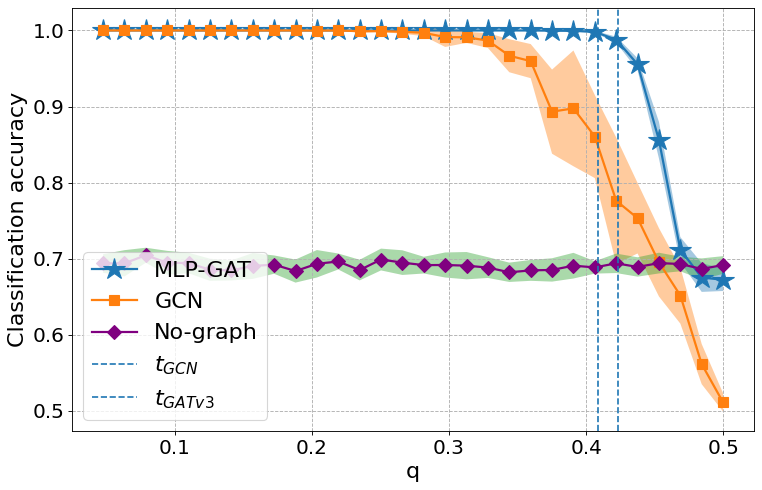

In [13]:
import math

fig = plt.figure(figsize=(11, 7), dpi=80)

plt.plot(qs,acc_mlp_gat, linewidth=2, linestyle='-', marker='*', markersize=20,  label='GATv3')
plt.fill_between(qs,np.asarray(acc_mlp_gat)-np.asarray(acc_mlp_gat_std),np.asarray(acc_mlp_gat)+np.asarray(acc_mlp_gat_std),alpha=0.4)

# plt.plot(qs,acc_gat, linewidth=2, linestyle='-', marker='X', markersize=9,  label='GAT')
# plt.fill_between(qs,np.asarray(acc_gat)-np.asarray(acc_gat_std),np.asarray(acc_gat)+np.asarray(acc_gat_std),alpha=0.4)

plt.plot(qs,acc_gcn, linewidth=2, linestyle='-', marker='s', markersize=9,  label='GCN')
plt.fill_between(qs,np.asarray(acc_gcn)-np.asarray(acc_gcn_std),np.asarray(acc_gcn)+np.asarray(acc_gcn_std),alpha=0.4)

plt.plot(qs,acc_lin, linewidth=2, linestyle='-', marker='D', markersize=9, color = 'purple', label='No-graph')
plt.fill_between(qs,np.asarray(acc_lin)-np.asarray(acc_lin_std),np.asarray(acc_lin)+np.asarray(acc_lin_std),alpha=0.4)

plt.axvline(x=(9*p)/11, label="$t_{GCN}$", linestyle="dashed")
val = p - (p * math.log(n)/(100*n))**(1/4)
plt.axvline(x=val, label="$t_{GATv3}$", linestyle="dashed")

plt.grid(linestyle='dashed')
plt.legend(fontsize=20)
plt.xscale('linear')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xlabel('q', fontsize=20)
plt.ylabel('Classification accuracy', fontsize=20)

fig.savefig("figures/node_classification_GATv3_varying_q_hard_regime_p_05_extra_lines.pdf", dpi=400, bbox_inches='tight')

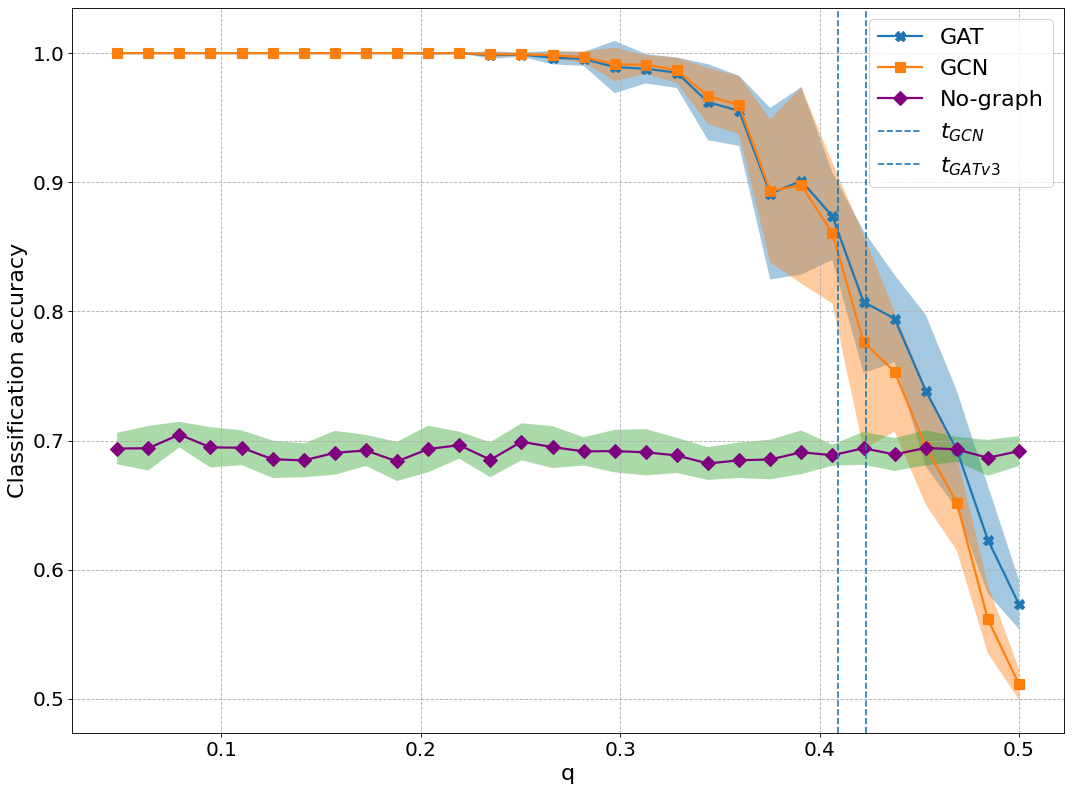

In [14]:
fig = plt.figure(figsize=(16, 12), dpi=80)

# plt.plot(qs,acc_mlp_gat, linewidth=2, linestyle='-', marker='*', markersize=20,  label='MLP-GAT')
# plt.fill_between(qs,np.asarray(acc_mlp_gat)-np.asarray(acc_mlp_gat_std),np.asarray(acc_mlp_gat)+np.asarray(acc_mlp_gat_std),alpha=0.4)

plt.plot(qs,acc_gat, linewidth=2, linestyle='-', marker='X', markersize=9,  label='GAT')
plt.fill_between(qs,np.asarray(acc_gat)-np.asarray(acc_gat_std),np.asarray(acc_gat)+np.asarray(acc_gat_std),alpha=0.4)

plt.plot(qs,acc_gcn, linewidth=2, linestyle='-', marker='s', markersize=9,  label='GCN')
plt.fill_between(qs,np.asarray(acc_gcn)-np.asarray(acc_gcn_std),np.asarray(acc_gcn)+np.asarray(acc_gcn_std),alpha=0.4)

plt.plot(qs,acc_lin, linewidth=2, linestyle='-', marker='D', markersize=9, color = 'purple', label='No-graph')
plt.fill_between(qs,np.asarray(acc_lin)-np.asarray(acc_lin_std),np.asarray(acc_lin)+np.asarray(acc_lin_std),alpha=0.4)

plt.axvline(x=(9*p)/11, label="$t_{GCN}$", linestyle="dashed")
val = p - (p * math.log(n)/(100*n))**(1/4)
plt.axvline(x=val, label="$t_{GATv3}$", linestyle="dashed")

plt.grid(linestyle='dashed')
plt.legend(fontsize=20)
plt.xscale('linear')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xlabel('q', fontsize=20)
plt.ylabel('Classification accuracy', fontsize=20)

fig.savefig("figures/node_classification_GAT_varying_q_hard_regime_p_05_extra_lines.pdf", dpi=400, bbox_inches='tight')

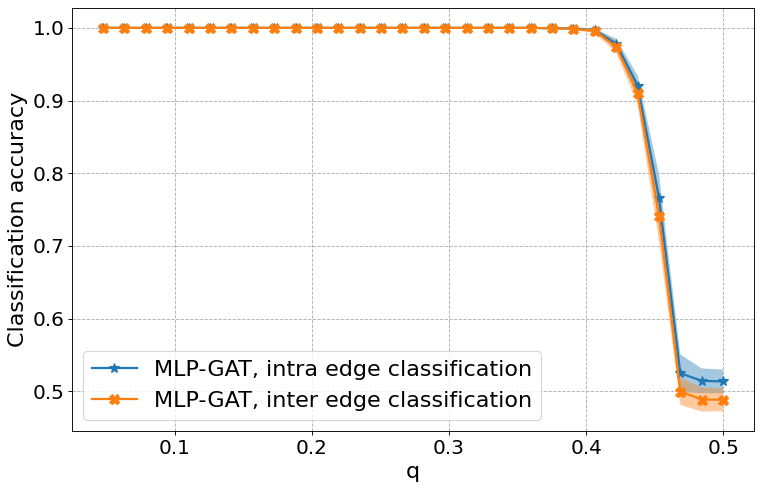

In [16]:
fig = plt.figure(figsize=(11, 7), dpi=80)

plt.plot(qs,acc_pairs_intra, linewidth=2, linestyle='-', marker='*', markersize=9, label='GATv3, intra edge classification')
plt.fill_between(qs,np.asarray(acc_pairs_intra)-np.asarray(acc_pairs_intra_std),np.asarray(acc_pairs_intra)+np.asarray(acc_pairs_intra_std),alpha=0.4)

plt.plot(qs,acc_pairs_inter, linewidth=2, linestyle='-', marker='X', markersize=9, label='GATv3, inter edge classification')
plt.fill_between(qs,np.asarray(acc_pairs_inter)-np.asarray(acc_pairs_inter_std),np.asarray(acc_pairs_inter)+np.asarray(acc_pairs_inter_std),alpha=0.4)

# plt.axvline(x=(9*p)/11, label="$t_{GCN}$", linestyle="dashed")
# val = p - (p * math.log(n)/(100*n))**(1/4)
# plt.axvline(x=val, label="$t_{GATv3}$", linestyle="dashed")

plt.grid(linestyle='dashed')
plt.legend(fontsize=20)
plt.xscale('linear')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xlabel('q', fontsize=20)
plt.ylabel('Classification accuracy', fontsize=20)

fig.savefig("figures/edge_classification_varying_q_hard_regime_p_05_extra_lines.pdf", dpi=400, bbox_inches='tight')